# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

/bin/bash: nvidia-smi: command not found


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
root_path = 'gdrive/My Drive/GestureRecognition/'
#https://drive.google.com/file/d/1Aaqc_Psup7SP4uclbHwa2OPSfOmx-uvM/view?usp=share_link # Data shared in following location

In [3]:
!gdown --id 1Aaqc_Psup7SP4uclbHwa2OPSfOmx-uvM -O 'Project_data.zip' && unzip -q 'Project_data.zip' -d 'Project_data'


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Aaqc_Psup7SP4uclbHwa2OPSfOmx-uvM
To: /content/Project_data.zip
100% 1.71G/1.71G [00:13<00:00, 123MB/s]


In [4]:
import os

# Set the base path to the Project_data directory
base_path = '/content/Project_data/Project_data'

# Get the full path to the train.csv file
train_csv_path = os.path.join(base_path,  'train.csv')

# Get the full path to the val.csv file
val_csv_path = os.path.join(base_path,  'val.csv')

# Print the full paths
print(train_csv_path)
print(val_csv_path)

/content/Project_data/Project_data/train.csv
/content/Project_data/Project_data/val.csv


# New Section

In [5]:
import numpy as np
import os
import imageio

#from scipy.misc import imread, imresize
import datetime
import os
import cv2

We set the random seed so that the results don't vary drastically.

In [16]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)
from skimage.transform import resize, rescale
import matplotlib.pyplot as plt


*In* this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [26]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
train_doc = np.random.permutation(open('/content/Project_data/Project_data/train.csv').readlines())
#Project_data/Project_data
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/Project_data/val.csv').readlines())
#batch_size = #experiment with the batch size
batch_size = 10
num_classes = 5  #number of softmax classes


In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/Project_data/train'
val_path = '/content/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


In [ ]:
Common Utils

In [31]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [30]:
#Common utility to calculate steps


def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [29]:
#Common utility for callbacks

def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]  

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

<ipython-input-17-7433f94724a4>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread("/content/Project_data/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
<ipython-input-17-7433f94724a4>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread("/content/Project_data/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")


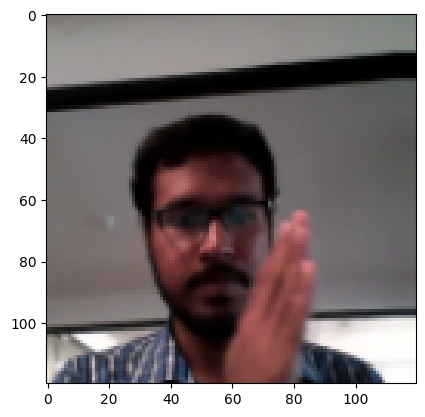

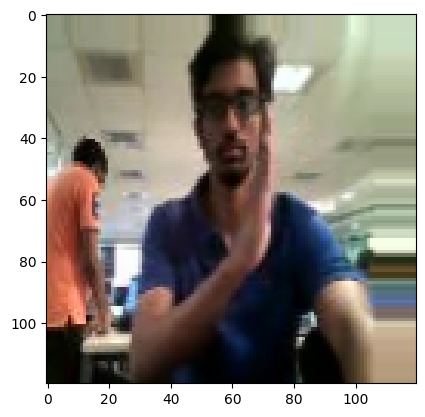

In [17]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("/content/Project_data/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
#160 by 120
image2 = imageio.imread("/content/Project_data/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()
## Test code end

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [18]:
curr_dt_time = datetime.datetime.now()
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
train_path = '/content/Project_data/Project_data/train'

#val_path = '/notebooks/storage/Final_data/Collated_training/val'
val_path = '/content/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
   # initialising the batch size, frames to sample and the no. of epochs
  # def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
   #     self.frames_to_sample=frames_to_sample
    #    self.batch_size=batch_size
     #   self.num_epochs=num_epochs

In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation

#from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Conv3d Models


In [24]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)


In [27]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_11 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_11 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.



In [32]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-33-6cd55824bb51>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-17-7433f94724a4>:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
65/67 [============================>.] - ETA: 50s - loss: 1.5822 - categorical_accuracy: 0.4031 

<ipython-input-17-7433f94724a4>:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5841 - categorical_accuracy: 0.4027 
Epoch 1: val_loss improved from inf to 2.29312, saving model to model_conv3D_1_2023-05-1715_48_40.170613/model-00001-1.58406-0.40271-2.29312-0.28000.h5
67/67 [==============================] - 1767s 26s/step - loss: 1.5841 - categorical_accuracy: 0.4027 - val_loss: 2.2931 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/25
 7/67 [==>...........................] - ETA: 24:30 - loss: 1.3668 - categorical_accuracy: 0.4714

In [ ]:
plot_loss_accuracy(history)


Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)


In [ ]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())



```
# This is formatted as code
```

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.



In [ ]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)